In [1]:
import pennylane as qml
import numpy as np
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = 2 * y - 1  

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train[:, :4], dtype=torch.float32)
X_test = torch.tensor(X_test[:, :4], dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [4]:
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")
def quantum_neural_network(x, weights):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    for layer in range(len(weights)):
        for i in range(n_qubits):
            qml.RY(weights[layer][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.expval(qml.PauliZ(0))

In [5]:
num_layers = 3
weights = torch.randn((num_layers, n_qubits), requires_grad=True)
def loss_fn(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)
optimizer = optim.Adam([weights], lr=0.1)
epochs = 5
batch_size = 16
loss_history = []

In [6]:
for epoch in range(epochs):
    epoch_loss = 0
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        y_pred = torch.stack([quantum_neural_network(x, weights) for x in X_batch])
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    avg_loss = epoch_loss / (len(X_train) / batch_size)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/5, Loss: 0.4304
Epoch 2/5, Loss: 0.3910
Epoch 3/5, Loss: 0.3710
Epoch 4/5, Loss: 0.3745
Epoch 5/5, Loss: 0.3711


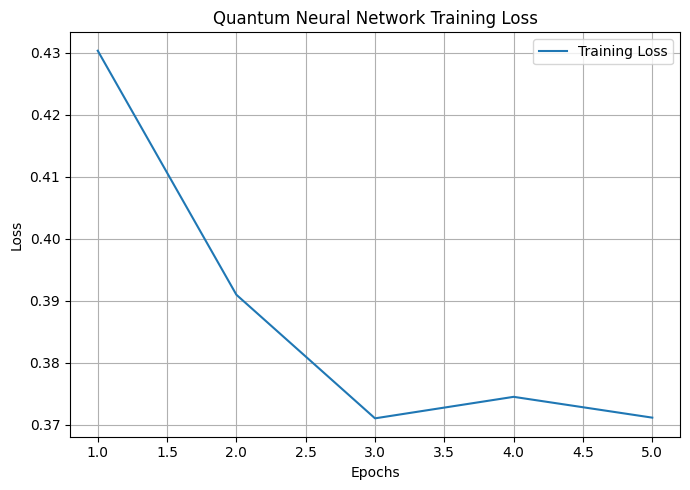

In [7]:
plt.figure(figsize=(7, 5))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Quantum Neural Network Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [8]:
with torch.no_grad():
    y_test_pred = torch.stack([quantum_neural_network(x, weights) for x in X_test])
    y_test_pred = torch.sign(y_test_pred)
    accuracy = (y_test_pred == y_test).sum().item() / len(y_test)
    print(f"\n Test Accuracy: {accuracy * 100:.2f}%")


 Test Accuracy: 89.47%


In [9]:
sample_x = X_train[0]
sample_weights = weights.detach().clone()
@qml.qnode(dev)
def feature_map(x):
    for i in range(n_qubits):
        qml.RY(x[i], wires=i)
    return qml.state()
@qml.qnode(dev)
def variational_encoder(weights):
    for layer in range(len(weights)):
        for i in range(n_qubits):
            qml.RY(weights[layer][i], wires=i)
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
    return qml.state()

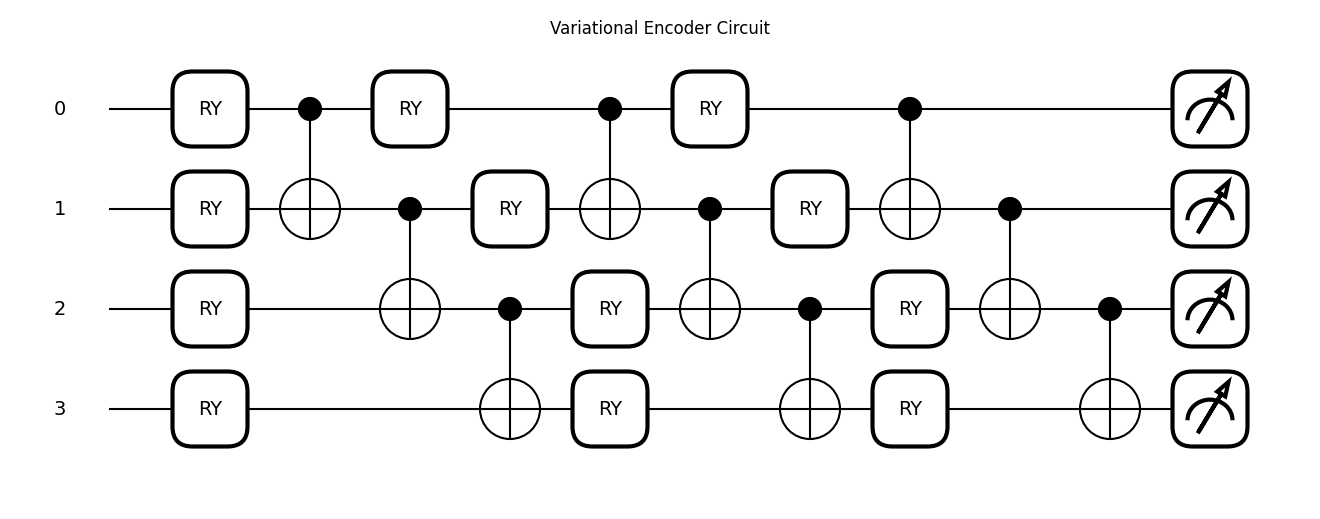

In [10]:
fig2, ax2 = qml.draw_mpl(variational_encoder)(sample_weights)
fig2.suptitle("Variational Encoder Circuit")
plt.show()

In [13]:
test_index = 0
test_sample = X_test[test_index]
true_label = (y_test[test_index].item() + 1) / 2  
with torch.no_grad():
    raw_output = quantum_neural_network(test_sample, weights)
    activated_output = sigmoid(raw_output)
    predicted_label = 1.0 if activated_output >= 0.5 else 0.0
print("\n--- Test Case ---")
print(f"Input features     : {test_sample}")
print(f"Raw QNN output     : {raw_output.item():.4f}")
print(f"Sigmoid probability: {activated_output.item():.4f}")
print(f"Predicted label    : {int(predicted_label)}")
print(f"Actual label       : {int(true_label)}")


--- Test Case ---
Input features     : tensor([-0.4707, -0.1605, -0.4481, -0.4920])
Raw QNN output     : 0.5111
Sigmoid probability: 0.6251
Predicted label    : 1
Actual label       : 1
